# 2018/2019 English Premier League Football Data Model

### Udacity Data Engineering Nanodegree Capstone Project

##### Project Summary

The purpose of the data Engineering Capstone Project is to combine and showcase the technologies and techniques learned throughout the program. I decided to collect and combine data on the 2018/2019 English Premier League Season to create a comprehensive data model that is easy to visualise for beginners using Tableau Desktop Public.

---

### Step 1: Scope the Project and Gather Data

I chose data from three seperate sources both due to complexity, completeness and availability of what I was trying to create:

1. [RapidAPI - API-Football](https://rapidapi.com/api-sports/api/api-football) - JSON Format

The RapidAPI Football includes data on +630 football leagues & cups. Livescore (15s), odds, events, line-ups, coaches, players, top scorers, standings, statistics, transfers and match result predictions. This API was used to extract the majority of the data used in the project. From this source I extracted player season stats, team season stats, match events, individual fixture stats, fixture lineups, league standings and team squads.

2. [Fifa 2019 Player Ratings - Kaggle Dataset](https://www.kaggle.com/karangadiya/fifa19) - CSV Format

This publicly available kaggle dataset includes detailed attributes for every player registered in the latest edition of FIFA 19 database. This data is originally scraped from https://sofifa.com/ and is joined to each player to provide some additional perspective on their season performance and expectations given their in game rating.

3. [Fantasy Premier League Performance](https://github.com/vaastav/Fantasy-Premier-League) - CSV Format

The final piece of the data model is a Fantasy Premier League library that gets all the basic stats for each player, gameweek-specific data for each player and season history of each player, including how many fantasy players have selected a particular player for each gameweek round. I forked this repository on github before uploading the csv files to the project workspace. For more information on fantasy football see here:  
https://fantasy.premierleague.com/

##### Data Architecture

When deciding upon the data architecture for storing and processing the chosen data, I tried to incorporate as many of the previously used technologies and best practices demonstrated in the course as possible.

I used an amazon S3 bucket as a generic file storage for the JSON and CSV files in a pre-staging capacity. I then loaded these files to a staging area in Amazon Redshift cloud relational datawarehouse before processing the staged data into final analytical tables in redshift using the distributed power of Apache Spark. Once the ETL Pipeline had been tested it was automated and scheduled using Apache Airflow. More detail on the nuances of the pipeline itself can be found in section 4.

---

### Step 2: Explore and Assess the Data

Given the large number of csv and json files that are downloaded, it is not feasible to explore each of these files for inconsistencies by eye prior to staging in S3 and Redshift. Instead, I will explore 1 of each file type from each of the different data sources. As a more production ready solution I have included logic into the downloading scripts that will automatically delete a json file downloaded from the api if it does not pass a data quality threshold. Furthermore, a custom data quality operator is included in the airflow dag that checks the data after it has been loaded and transformed in Redshift.

#### Let's set up the dependencies and imports

In [1]:
import requests
import pandas as pd
import json
import itertools
from pandas.io.json import json_normalize
import time
from datetime import datetime
import shutil
import logging
import boto3
from botocore.exceptions import ClientError
import os
from os import listdir
from os.path import isfile, join
import sys
import helper_functions as helpers
import configparser
import psycopg2
from sqlalchemy import create_engine

# Read in the configuration specifications
config = configparser.ConfigParser()
config.read('/home/workspace/gh_project/Configs/ars.cfg')

['/home/workspace/gh_project/Configs/ars.cfg']

Read in the API host and key

In [55]:
# Set the API headers
headers = {
'x-rapidapi-host': config["API"]['X-RAPIDAPI-HOST'],
'x-rapidapi-key': config["API"]['X-RAPIDAPI-KEY']
          }

---

Examining the Teams Dataset

---

Requesting data from https://api-football-v1.p.rapidapi.com/v2/teams/league/2
Response collected from https://api-football-v1.p.rapidapi.com/v2/teams/league/2
Extracting json data from response
Data extracted
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 12 columns):
code              1 non-null object
country           20 non-null object
founded           20 non-null int64
is_national       20 non-null bool
logo              20 non-null object
name              20 non-null object
team_id           20 non-null int64
venue_address     20 non-null object
venue_capacity    20 non-null int64
venue_city        20 non-null object
venue_name        20 non-null object
venue_surface     20 non-null object
dtypes: bool(1), int64(3), object(8)
memory usage: 1.8+ KB
None
           founded   team_id  venue_capacity
count    20.000000  20.00000       20.000000
mean   1888.900000  42.50000    39905.250000
std      10.130205   5.91608    17126.615052
min   

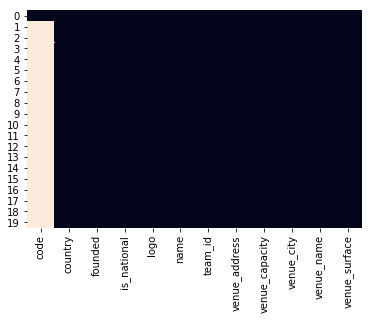

In [56]:
# extract the api response data for the teams dataset
api_url = "https://api-football-v1.p.rapidapi.com/v2/teams/league/2"
data = helpers.api_extract(api_url, headers)
data_nested = data["api"]['teams']
flattened = json_normalize(data_nested, sep = "_")
df = pd.DataFrame(flattened)

# Explore the structure of the data and check for missing values and duplicate rows
helpers.explore_data(df)

About 7.9% of the total teams dataset is missing. On close inspection though the **code** column is the only variable with missing values. We will drop this column later from the final analytical tables as it has little or no value to our main objective. Thankfully we have no duplicate columns.

---

Examining the Standings dataset

---


Requesting data from https://api-football-v1.p.rapidapi.com/v2/leagueTable/2
Response collected from https://api-football-v1.p.rapidapi.com/v2/leagueTable/2
Extracting json data from response
Data extracted
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 29 columns):
all_draw             20 non-null int64
all_goalsAgainst     20 non-null int64
all_goalsFor         20 non-null int64
all_lose             20 non-null int64
all_matchsPlayed     20 non-null int64
all_win              20 non-null int64
away_draw            20 non-null int64
away_goalsAgainst    20 non-null int64
away_goalsFor        20 non-null int64
away_lose            20 non-null int64
away_matchsPlayed    20 non-null int64
away_win             20 non-null int64
description          9 non-null object
forme                20 non-null object
goalsDiff            20 non-null int64
group                20 non-null object
home_draw            20 non-null int64
home_goalsAgainst    20 n

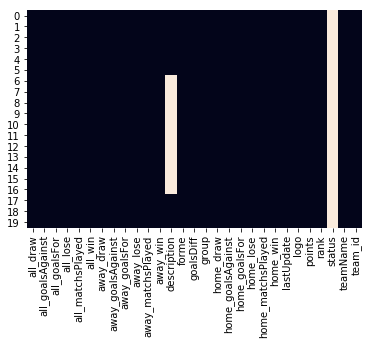

In [57]:
# extract the api response data for the standings dataset
api_url = "https://api-football-v1.p.rapidapi.com/v2/leagueTable/2"
data = helpers.api_extract(api_url, headers)
data_nested = data['api']['standings'][0]
flattened = json_normalize(data_nested, sep = "_")
df = pd.DataFrame(flattened)

# Explore the structure of the data and check for missing values and duplicate rows
helpers.explore_data(df)

The **status** column looks to be completely redundant here including only null values and hence will be removed from the final tables. The **description** column is also nearly 50% null values. **Description** in our context describes if the position a team holds in the league invokes any special conditions, for example position 1 would be champions, 3 would mean qualification to the champions league european competition and 19 would mean the team has been relegated to the division below. For this reason we will hold on to the description column for now and coalesce the null values in later transformations.

---

Examining the Squads dataset

---

Requesting data from https://api-football-v1.p.rapidapi.com/v2/players/squad/33/2018-2019
Response collected from https://api-football-v1.p.rapidapi.com/v2/players/squad/33/2018-2019
Extracting json data from response
Data extracted
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 13 columns):
age              31 non-null int64
birth_country    31 non-null object
birth_date       31 non-null object
birth_place      30 non-null object
firstname        31 non-null object
height           31 non-null object
lastname         31 non-null object
nationality      31 non-null object
number           0 non-null object
player_id        31 non-null int64
player_name      31 non-null object
position         31 non-null object
weight           29 non-null object
dtypes: int64(2), object(11)
memory usage: 3.2+ KB
None
             age     player_id
count  31.000000     31.000000
mean   28.032258   4168.612903
std     5.173547  16161.338088
min    19.000000   

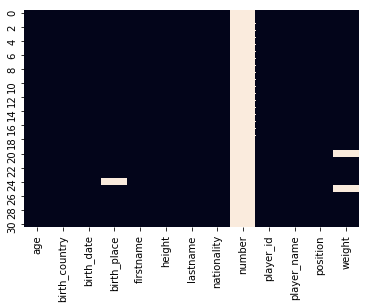

In [58]:
# extract the api response data for the squads dataset - test set is Manchester United team_id 33
api_url = "https://api-football-v1.p.rapidapi.com/v2/players/squad/33/2018-2019"
data = helpers.api_extract(api_url, headers)
data_nested = data['api']['players']
flattened = json_normalize(data_nested, sep = "_")
df = pd.DataFrame(flattened)

# Explore the structure of the data and check for missing values and duplicate rows
helpers.explore_data(df)

From our test squad, Manchester United, we can see the squad **number** column is redundant and includes only null values. We have a couple of missing values accross the player **weight** and the **birth_place** columns. This may not be ideal, however weight and birthplace are not fundamental to our analysis later on, particularly if these values are only missing for players that have not played any games throughout the season.

---

Examining the Player Season Stats Dataset

---

Requesting data from https://api-football-v1.p.rapidapi.com/v2/players/team/33/2018-2019
Response collected from https://api-football-v1.p.rapidapi.com/v2/players/team/33/2018-2019
Extracting json data from response
Data extracted
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 51 columns):
age                      106 non-null int64
birth_country            106 non-null object
birth_date               106 non-null object
birth_place              104 non-null object
captain                  106 non-null int64
cards_red                106 non-null int64
cards_yellow             106 non-null int64
cards_yellowred          106 non-null int64
dribbles_attempts        106 non-null int64
dribbles_success         106 non-null int64
duels_total              106 non-null int64
duels_won                106 non-null int64
firstname                106 non-null object
fouls_committed          106 non-null int64
fouls_drawn              106 non-null int64


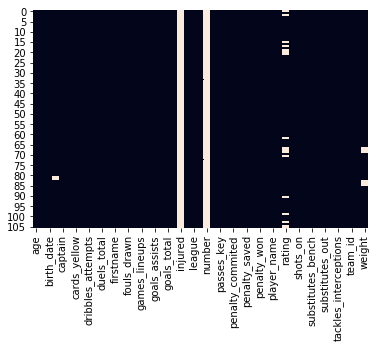

In [59]:
# extract the api response data for the player stats dataset - test set is Manchester United team_id 33
api_url = "https://api-football-v1.p.rapidapi.com/v2/players/team/33/2018-2019"
data = helpers.api_extract(api_url, headers)
data_nested = data['api']['players']
flattened = json_normalize(data_nested, sep = "_")
df = pd.DataFrame(flattened)

# Explore the structure of the data and check for missing values and duplicate rows
helpers.explore_data(df)

For the player season stats dataset both **injured** and **number** are missing in totality. Rating is missing on purpose in places as certain players have not made any appearances and therefore cannot be rated. It is also worth noting that there is 106 observations for player season stats in a squad of 31 players. This is because this API actually provides stats for all competitions the team has appeared in for a given season, something to keep in mind when staging this data.

---

Examining the Player Stats by Fixture Dataset

---

Requesting data from https://api-football-v1.p.rapidapi.com/v2/players/fixture/65
Response collected from https://api-football-v1.p.rapidapi.com/v2/players/fixture/65
Extracting json data from response
Data extracted
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 38 columns):
captain                  28 non-null object
cards_red                28 non-null int64
cards_yellow             28 non-null int64
dribbles_attempts        28 non-null int64
dribbles_past            28 non-null int64
dribbles_success         28 non-null int64
duels_total              28 non-null int64
duels_won                28 non-null int64
event_id                 28 non-null int64
fouls_committed          28 non-null int64
fouls_drawn              28 non-null int64
goals_assists            28 non-null int64
goals_conceded           28 non-null int64
goals_total              28 non-null int64
minutes_played           28 non-null int64
number                   28 non-nu

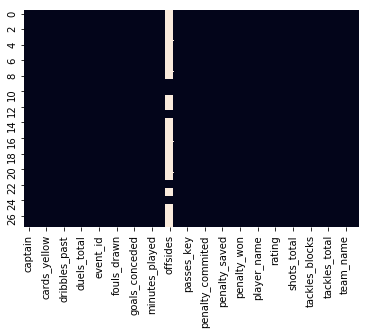

In [60]:
# extract the api response data for the player stats by fixture dataset - test set is Manchester United vs Leicester 
# fixture_id 65
api_url = "https://api-football-v1.p.rapidapi.com/v2/players/fixture/65"
data = helpers.api_extract(api_url, headers)
data_nested = data['api']['players']
flattened = json_normalize(data_nested, sep = "_")
df = pd.DataFrame(flattened)

# Explore the structure of the data and check for missing values and duplicate rows
helpers.explore_data(df)

For our test fixture Manchester United vs Leicester City the data is almost complete across all columns. The **offsides** column includes some null values that are missing on purpose because not every player is guaranteed to be in an offside position for each fixture. Later, we will coalesce this value to 0 for consistency.

---

Examining the Fixture List dataset

---

Requesting data from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Response collected from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Extracting json data from response
Data extracted
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 28 columns):
awayTeam_logo         380 non-null object
awayTeam_team_id      380 non-null int64
awayTeam_team_name    380 non-null object
elapsed               380 non-null int64
event_date            380 non-null object
event_timestamp       380 non-null int64
firstHalfStart        380 non-null int64
fixture_id            380 non-null int64
goalsAwayTeam         380 non-null int64
goalsHomeTeam         380 non-null int64
homeTeam_logo         380 non-null object
homeTeam_team_id      380 non-null int64
homeTeam_team_name    380 non-null object
league_country        380 non-null object
league_flag           380 non-null object
league_id   

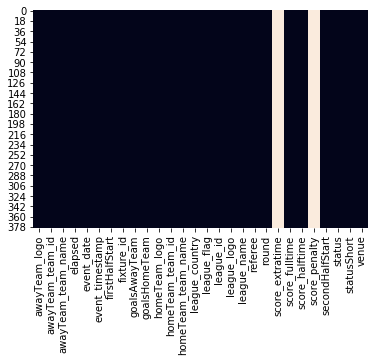

In [61]:
# extract the api response data for all fixtures for the 2018/2019 English Premier League Season
api_url = "https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London"
data = helpers.api_extract(api_url, headers)
data_nested = data['api']['fixtures']
flattened = json_normalize(data_nested, sep = "_")
df = pd.DataFrame(flattened)

# Explore the structure of the data and check for missing values and duplicate rows
helpers.explore_data(df)

The fixtures-list dataset returned exactly 380 fixtures which we expect for a league of 20 teams that all player each other twice in a season (20x19). The only null columns in this instance are **score_extratime** and **score_penalty**, both of which refer to events that cannot regularly occur during league matches. Extra time and penalties are used to decide cup competitions where the score is still level after 90 minutes. We can expect these columns to be null and they will be removed from the analysis tables.

---

Examining the high level fixture stats dataset

---

Requesting data from https://api-football-v1.p.rapidapi.com/v2/statistics/fixture/65
Response collected from https://api-football-v1.p.rapidapi.com/v2/statistics/fixture/65
Extracting json data from response
Data extracted
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 32 columns):
Ball Possession_away     1 non-null object
Ball Possession_home     1 non-null object
Blocked Shots_away       1 non-null object
Blocked Shots_home       1 non-null object
Corner Kicks_away        1 non-null object
Corner Kicks_home        1 non-null object
Fouls_away               1 non-null object
Fouls_home               1 non-null object
Goalkeeper Saves_away    1 non-null object
Goalkeeper Saves_home    1 non-null object
Offsides_away            1 non-null object
Offsides_home            1 non-null object
Passes %_away            1 non-null object
Passes %_home            1 non-null object
Passes accurate_away     1 non-null object
Passes accurate_home     1 non-

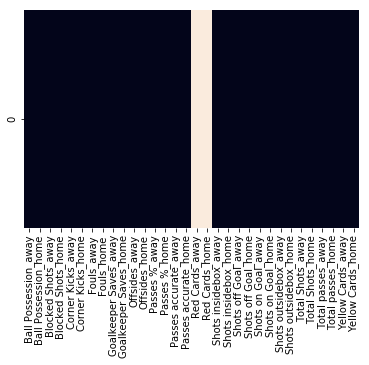

In [62]:
# extract the api response data for high level fixture stats - test set is Manchester United vs Leicester
api_url = "https://api-football-v1.p.rapidapi.com/v2/statistics/fixture/65"
data = helpers.api_extract(api_url, headers)
data_nested = data['api']['statistics']
flattened = json_normalize(data_nested, sep = "_")
df = pd.DataFrame(flattened)

# Explore the structure of the data and check for missing values and duplicate rows
helpers.explore_data(df)

The only columns including null values in the high level fixture stats dataset appear to be columns related to events that did not occur in a game. For example, in the match in question, Manchester United vs Leicester, there were no red cards receieved by either the home or away teams and hence the values are displayed as null on purpose. For consistency we may need to coalesce each of these columns null values with 0.

---

Examining the fixture in game events dataset

---

Requesting data from https://api-football-v1.p.rapidapi.com/v2/events/65
Response collected from https://api-football-v1.p.rapidapi.com/v2/events/65
Extracting json data from response
Data extracted
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 11 columns):
assist          7 non-null object
assist_id       7 non-null float64
comments        0 non-null object
detail          12 non-null object
elapsed         12 non-null int64
elapsed_plus    1 non-null float64
player          12 non-null object
player_id       12 non-null int64
teamName        12 non-null object
team_id         12 non-null int64
type            12 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 1.1+ KB
None
          assist_id    elapsed  elapsed_plus     player_id    team_id
count      7.000000  12.000000           1.0     12.000000  12.000000
mean    7818.714286  65.250000           2.0   4237.083333  38.416667
std     8619.036696  23.049847           

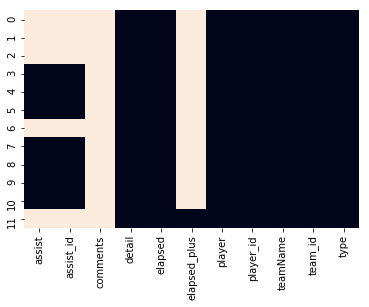

In [63]:
# extract the api response data for fixture in game events - test set is Manchester United vs Leicester
api_url = "https://api-football-v1.p.rapidapi.com/v2/events/65"
data = helpers.api_extract(api_url, headers)
data_nested = data['api']['events']
flattened = json_normalize(data_nested, sep = "_")
df = pd.DataFrame(flattened)

# Explore the structure of the data and check for missing values and duplicate rows
helpers.explore_data(df)

The fixture events dataset for our sample fixture, Manchester United vs Leicester, shows 25% of the data are null values. At first this may seem alarming but on closer inspection we can determine that the **comments** column is redundant and can be removed as it does not contribute to the end goal. **Elapsed_plus** refers to events that have occured past the regulation match time i.e. 45 minutes for each half. Thus, we know that any event that occured during regulation time will be represented by a null value in **elapsed_plus**. The columns **assist** and **assist_id** seem to follow a particular pattern in the locations of their missing data, suggesting these values are missing on purpose. This is indeed the case as not all events recorded require an assist from another player and will be recorded as null for events such as a yellow card.

---

Examining the Season Overall Fantasy Stats Ratings

---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 19 columns):
first_name             624 non-null object
second_name            624 non-null object
goals_scored           624 non-null int64
assists                624 non-null int64
total_points           624 non-null int64
minutes                624 non-null int64
goals_conceded         624 non-null int64
creativity             624 non-null float64
influence              624 non-null float64
threat                 624 non-null int64
bonus                  624 non-null int64
bps                    624 non-null int64
ict_index              624 non-null float64
clean_sheets           624 non-null int64
red_cards              624 non-null int64
yellow_cards           624 non-null int64
selected_by_percent    624 non-null float64
now_cost               624 non-null int64
player_id              624 non-null int64
dtypes: float64(4), int64(13), object(2)
memory usage: 92.7+ KB
None
       goals_score

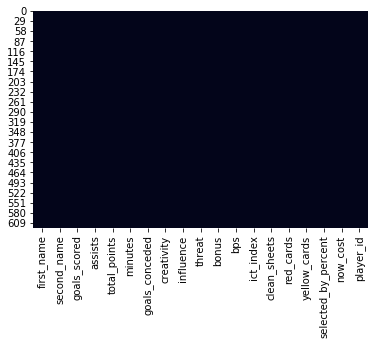

In [64]:
# read in the csv for the season overall fantasy stats ratings
df = pd.read_csv('/home/workspace/gh_project/Data/fantasy-ratings/overall/cleaned_players.csv')
# Explore the structure of the data and check for missing values and duplicate rows
helpers.explore_data(df)

Fortunately, there are no missing values or duplicate values in the fantasy premier league season stats for each player. This dataset was exceptionally collected and maintained to avoid this.

---

Examining the FIFA 19 Game data

---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
Unnamed: 0                  18207 non-null int64
ID                          18207 non-null int64
Name                        18207 non-null object
Age                         18207 non-null int64
Photo                       18207 non-null object
Nationality                 18207 non-null object
Flag                        18207 non-null object
Overall                     18207 non-null int64
Potential                   18207 non-null int64
Club                        17966 non-null object
Club Logo                   18207 non-null object
Value                       18207 non-null object
Wage                        18207 non-null object
Special                     18207 non-null int64
Preferred Foot              18159 non-null object
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null fl

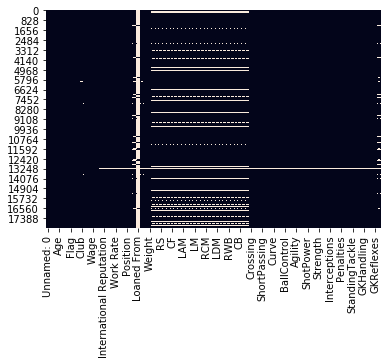

In [65]:
# read in the csv for the FIFA 19 game data
df = pd.read_csv('/home/workspace/gh_project/Data/fifa-ratings/fifa_19_data.csv')
# Explore the structure of the data and check for missing values and duplicate rows
helpers.explore_data(df)

The FIFA 19 game data includes ratings for players in almost all major international leagues. Nearly 5% of this data is represented by null values. It is difficult to tell the impact on the database at this point as we will only be extracting FIFA 19 game stats for premier league players by joining on their name across the two datasets. 

---

Examining the gameweek level fantasy stats data

---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 54 columns):
assists                            525 non-null int64
attempted_passes                   525 non-null int64
big_chances_created                525 non-null int64
big_chances_missed                 525 non-null int64
bonus                              525 non-null int64
bps                                525 non-null int64
clean_sheets                       525 non-null int64
clearances_blocks_interceptions    525 non-null int64
completed_passes                   525 non-null int64
creativity                         525 non-null float64
dribbles                           525 non-null int64
ea_index                           525 non-null int64
element                            525 non-null int64
errors_leading_to_goal             525 non-null int64
errors_leading_to_goal_attempt     525 non-null int64
fixture                            525 non-null int64
fouls                        

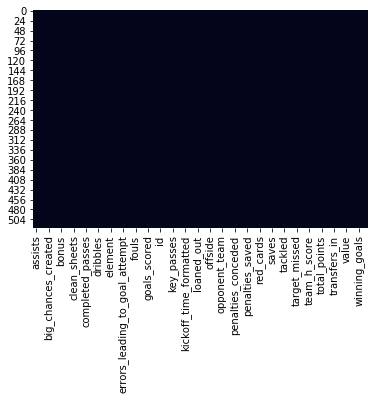

In [66]:
# read in the csv for the gameweek level fantasy stats ratings
# Must remove the name column as it contains special characters that cannot be easily read into a pandas dataframe
df = pd.read_csv('/home/workspace/gh_project/Data/fantasy-ratings/by-gameweek/gw1.csv', usecols=list(range(55))[1:])
# Explore the structure of the data and check for missing values and duplicate rows
helpers.explore_data(df)

As seen with the overall fantasy player stats for the season, gameweek 1 is also a complete dataset and ready for staging.

---

### Step 3: Define the Data Model

For the data model I tried to keep the table entities in as close to 3rd Normal Form as possible. In the view of a data analyst I anticipate there to be 4 focal points of interest in the data:

- The overall performance of a team across the season
- The overall performance of a player across a season
- The performance of a team in an individual fixture
- The performance of a player in an individual fixture

To accurately capture this structure while minimising the number of potential SQL joins required by a user I organised the table entities into groups of fact and dimension tables that represent somewhat of a snowflake schema.

The most important thing to take note when joining the staging tables together is the use of the player mapping table located in **/home/workspace/gh_project/Data/player_map/player_map_table.csv** and is also loaded to redshift for use as `staging_player_map_table`. This table consists of `original_player_id` (the player id extracted from each squad of the API data source) `fantasy_id` (the player_id from each player in the fantasy league stats data extract) and a `fifa_id` (the player_id for each player in the FIFA 19 data extract). I created this table to avoid any potential errors when joining on player names along as many player names include special characters, are duplicates or are inconsistent across the three sources.

These analytical table are described below. For further information see the schema diagram below and the data dictionary in Step 4:

Analytical Tables:

- **dimTeams:** *descriptive information about each of the teams in the Premier League for the 2018/2019 season*
- **dimPlayers:** *descriptive information about each of the players involved in the Premier League for the 2018/2019 season*
- **dimLeague:** *descriptive information about the league, in case the database in expanded past the Premier League season of 2018/19*
- **dimStandings:** *The league table rankings as of the final gameweek 38 at the end of the season*
- **dimFixtures:** *The list of all 380 fixtures and descriptive information about each fixture*
- **dimRounds:** *Unique identifier for each of the 38 gameweek rounds for the season*
- **dimSquads:** *A table that represents how each player is attached to a submitted team squad for the 2018/2019 season*
- **dimGameweekLineupDesc:** *A description of the line-up for each fixture such as formation and manager*
- **dimGameweekLineupPlayers:** *A table that represents the players and positions in a teams match day squad for each fixture*
- **factSeasonMetricsTeams:** *In depth statistics of each Teams performance for the season*
- **factSeasonMetricsPlayers:** *In depth statistics of each Players performance, FIFA rating and fantasy performance metrics for the season*
- **factGameweekMetricsTeams:** *In depth statistics of each Teams performance in a given fixture*
- **factGameweekMetricsPlayers:** *In depth statistics of each Players performance and fantasy metrics in a given fixture*
- **factFixtureEvents:** *Individual player match events for each fixture in the season, such as assits and yellow cards*


![Redshift Snowflake Schema](db-schema.png)

---

#### **Creating the data pipeline**

---

As described in the project summary the data pipeline I constructed used a number of technologies in unison: 

- **Step 1:** Clear out all local files and all keys used in S3 to avoid uploading old or defective/test files.
- **Step 2:** Upload the json filepaths to ensure Copy from S3 to Redshift will operate correctly.
- **Step 3:** Collect all of the CSV files and json files from the API or other repositories and upload them to the pre-staging S3 bucket. 
- **Step 4:** Create each of the staging tables in Amazon Redshift and copy each file over from S3 using a manifest on each key.
- **Step 5:** Join and transform the necessarystaging tables together using Apache Spark and upsert to Analytical tables in Redshift.
- **Step 6:** Complete data quality checks on the analytical tables.
- **Step 7:** Automate and schedule the pipeline using Apache airflow.

*See the Dag below as a sample for a flow diagram:*

![Football warehouse dag](dag.png)

---

### Step 4: Run ETL to Model the Data

This section will detail how to run this ETL pipeline manually from within the Ipython notebook. There are is also a working Airflow Dag provided along with instructions on how to set this up in the readme file.

---

Step 4.1: Clean out the local workspace and the S3 bucket

---

Firstly we will clear out any of the previous versions of the json files that have been downloaded to ensure we will be extracting the recently available data. The same goes for clearing out the pre-staging area in the s3 bucket to ensure we don't later copy over old or redundant files.

In [2]:
# S3 bucket object names
FANTASY_GW_DATA = config['S3']["FANTASY_GW_DATA"][(23-len(config['S3']["FANTASY_GW_DATA"])):]
FANTASY_OVERALL_DATA = config['S3']["FANTASY_OVERALL_DATA"][(23-len(config['S3']["FANTASY_OVERALL_DATA"])):]
FIFA_RATINGS_DATA = config['S3']["FIFA_RATINGS_DATA"][(23-len(config['S3']["FIFA_RATINGS_DATA"])):]
FIXTURE_EVENTS_DATA = config['S3']["FIXTURE_EVENTS_DATA"][(23-len(config['S3']["FIXTURE_EVENTS_DATA"])):]
LINEUP_DESCRIPTIVE_DATA = config['S3']["LINEUP_DESCRIPTIVE_DATA"][(23-len(config['S3']["LINEUP_DESCRIPTIVE_DATA"])):]
LINEUP_PLAYER_DATA = config['S3']["LINEUP_PLAYER_DATA"][(23-len(config['S3']["LINEUP_PLAYER_DATA"])):]
FIXTURE_LIST_DATA = config['S3']["FIXTURE_LIST_DATA"][(23-len(config['S3']["FIXTURE_LIST_DATA"])):]
FIXTURE_STATS_DATA = config['S3']["FIXTURE_STATS_DATA"][(23-len(config['S3']["FIXTURE_STATS_DATA"])):]
PLAYER_FIXTURE_STATS_DATA = config['S3']["PLAYER_FIXTURE_STATS_DATA"][(23-len(config['S3']["PLAYER_FIXTURE_STATS_DATA"])):]
PLAYER_STATS_DATA = config['S3']["PLAYER_STATS_DATA"][(23-len(config['S3']["PLAYER_STATS_DATA"])):]
ROUNDS_DATA = config['S3']["ROUNDS_DATA"][(23-len(config['S3']["ROUNDS_DATA"])):]
STANDINGS_DATA = config['S3']["STANDINGS_DATA"][(23-len(config['S3']["STANDINGS_DATA"])):]
TEAM_LIST_DATA = config['S3']["TEAM_LIST_DATA"][(23-len(config['S3']["TEAM_LIST_DATA"])):]
TEAM_SQUADS_DATA = config['S3']["TEAM_SQUADS_DATA"][(23-len(config['S3']["TEAM_SQUADS_DATA"])):]
PLAYER_MAP_DATA = config['S3']["PLAYER_MAP_DATA"][(23-len(config['S3']["PLAYER_MAP_DATA"])):]

home = '/home/workspace/gh_project/Data'

FIXTURE_EVENTS_FOLDER = home+config['LOCAL']["FIXTURE_EVENTS_FOLDER"]
LINEUP_DESCRIPTIVE_FOLDER = home+config['LOCAL']["LINEUP_DESCRIPTIVE_FOLDER"]
LINEUP_PLAYER_FOLDER = home+config['LOCAL']["LINEUP_PLAYER_FOLDER"]
FIXTURE_LIST_FOLDER = home+config['LOCAL']["FIXTURE_LIST_FOLDER"]
FIXTURE_STATS_FOLDER = home+config['LOCAL']["FIXTURE_STATS_FOLDER"]
PLAYER_FIXTURE_STATS_FOLDER = home+config['LOCAL']["PLAYER_FIXTURE_STATS_FOLDER"]
PLAYER_STATS_FOLDER = home+config['LOCAL']["PLAYER_STATS_FOLDER"]
ROUNDS_FOLDER = home+config['LOCAL']["ROUNDS_FOLDER"]
STANDINGS_FOLDER = home+config['LOCAL']["STANDINGS_FOLDER"]
TEAM_LIST_FOLDER = home+config['LOCAL']["TEAM_LIST_FOLDER"]
TEAM_SQUADS_FOLDER = home+config['LOCAL']["TEAM_SQUADS_FOLDER"]

my_bucket= config['S3']['DESTINATION_BUCKET']


local_dir_list = [FIXTURE_EVENTS_FOLDER, LINEUP_DESCRIPTIVE_FOLDER, \
                 LINEUP_PLAYER_FOLDER, FIXTURE_LIST_FOLDER, FIXTURE_STATS_FOLDER, PLAYER_FIXTURE_STATS_FOLDER, \
                 PLAYER_STATS_FOLDER, ROUNDS_FOLDER, STANDINGS_FOLDER, TEAM_LIST_FOLDER, TEAM_SQUADS_FOLDER]

s3_bucket_list = [FANTASY_GW_DATA, FANTASY_OVERALL_DATA, FIFA_RATINGS_DATA, FIXTURE_EVENTS_DATA, LINEUP_DESCRIPTIVE_DATA, \
                 LINEUP_PLAYER_DATA, FIXTURE_LIST_DATA, FIXTURE_STATS_DATA, PLAYER_FIXTURE_STATS_DATA, \
                 PLAYER_STATS_DATA, ROUNDS_DATA, STANDINGS_DATA, TEAM_LIST_DATA, TEAM_SQUADS_DATA, PLAYER_MAP_DATA]

ACCESS_KEY = config["CREDENTIALS"]['AWS_ACCESS_KEY_ID']
SECRET_KEY = config["CREDENTIALS"]['AWS_SECRET_ACCESS_KEY']

In [68]:
# Clean out the local Data capture files that usually hold the json files extracted from the APIs
helpers.file_deleter(local_dir_list)

In [69]:
# Set / read in the access credentials for the S3 bucket
s3_client = boto3.client('s3', aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY)
# Clean out the s3 bucket for pre-staging and recreate the object keys for loading the csv and json files
helpers.bucket_cleaner(dir_list=s3_bucket_list, home_bucket=my_bucket, \
                       s3_client=s3_client, ACCESS_KEY=ACCESS_KEY, SECRET_KEY=SECRET_KEY)

---

Step 4.2: Extract the data from the APIs and Upload to the pre-staging s3 Bucket

---

In this section we will extract all of the necessary data from each API as a json formatted file and upload it to the pre-staging s3 bucket. In the case of the CSV files, these will just be uploaded directly to s3 by running the dedicated scritps.

Each json file will need to be explicitly formatted to comply with redshifts particular required formats. Each file will also need to be accompanied by a jsonpath file to allow redshift to match up the table columns with the json file. More information on this can be found here:  
https://docs.aws.amazon.com/redshift/latest/dg/copy-usage_notes-copy-from-json.html

Please note that some of the API extracting scripts in this section will take command line arguments that modify the behaviour of the code in two of the following ways:

- `prod` 
will ensure the script is run in production mode, which will download every available file from the API endpoint which could be up to 380 files in one go. Not running the script in production mode significantly reduces the amount of time taken to download the data, using only a small subset of the total data required to give an overview of what the final data warehouse will look like.


- `wipe` 
will ensure each file that is uploaded to the s3 bucket is then subsequently deleted to the local environment before the next file is extracted and loaded to s3. This prevents your local workspace from being clogged up with lots of files that have already been uploaded to s3.

In [70]:
# Extracting and uploading teams data to s3
!python /home/workspace/gh_project/Downloading/teams_api_extract.py wipe

Requesting data from https://api-football-v1.p.rapidapi.com/v2/teams/league/2
Response collected from https://api-football-v1.p.rapidapi.com/v2/teams/league/2
Extracting json data from response
Data extracted
Shaping json format data for file write
Data quality passed at: 7.9%
Data formatting completed
/home/workspace/gh_project/Data/teams/teams--2020-07-08.json created successfully
Attempting to upload file: /home/workspace/gh_project/Data/teams/teams--2020-07-08.json to S3 bucket: gh-udac-deng-test as team_list/teams--2020-07-08.json
File successfully uploaded to S3
Uploading to s3 complete


In [71]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/player_stats_api_extract.py test wipe

Requesting data from https://api-football-v1.p.rapidapi.com/v2/teams/league/2
Response collected from https://api-football-v1.p.rapidapi.com/v2/teams/league/2
Extracting json data from response
Data extracted
Requesting data from https://api-football-v1.p.rapidapi.com/v2/players/team/33/2018-2019
Response collected from https://api-football-v1.p.rapidapi.com/v2/players/team/33/2018-2019
Extracting json data from response
Data extracted
Shaping json format data for file write
Data quality passed at: 4.3999999999999995%
Data formatting completed
/home/workspace/gh_project/Data/player-stats/player-stats-33-2020-07-08.json created successfully
Attempting to upload file: /home/workspace/gh_project/Data/player-stats/player-stats-33-2020-07-08.json to S3 bucket: gh-udac-deng-test as player_stats/player-stats-33-2020-07-08.json
File successfully uploaded to S3
Requesting data from https://api-football-v1.p.rapidapi.com/v2/players/team/46/2018-2019
Response collected from https://api-football-v

In [72]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/lineups_desc_api_extract.py test wipe

Requesting data from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Response collected from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Extracting json data from response
Data extracted
Requesting data from https://api-football-v1.p.rapidapi.com/v2/lineups/65
Response collected from https://api-football-v1.p.rapidapi.com/v2/lineups/65
Extracting json data from response
Data extracted
Attempting to upload file: /home/workspace/gh_project/Data/fixture-lineups/descriptive/lineup-description-65-2020-07-08.json to S3 bucket: gh-udac-deng-test as fixture_lineup_descriptive/lineup-description-65-2020-07-08.json
File successfully uploaded to S3
Requesting data from https://api-football-v1.p.rapidapi.com/v2/lineups/66
Response collected from https://api-football-v1.p.rapidapi.com/v2/lineups/66
Extracting json data from response
Data extracted
Attempting to upload file: /home/workspace/gh_project/Data/fixture-lineups/desc

In [73]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/lineups_players_api_extract.py test wipe

Requesting data from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Response collected from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Extracting json data from response
Data extracted
Requesting data from https://api-football-v1.p.rapidapi.com/v2/lineups/65
Response collected from https://api-football-v1.p.rapidapi.com/v2/lineups/65
Extracting json data from response
Data extracted
Attempting to upload file: /home/workspace/gh_project/Data/fixture-lineups/players/lineup-players-65-2020-07-08.json to S3 bucket: gh-udac-deng-test as fixture_lineup_players/lineup-players-65-2020-07-08.json
File successfully uploaded to S3
Requesting data from https://api-football-v1.p.rapidapi.com/v2/lineups/66
Response collected from https://api-football-v1.p.rapidapi.com/v2/lineups/66
Extracting json data from response
Data extracted
Attempting to upload file: /home/workspace/gh_project/Data/fixture-lineups/players/lineup-playe

In [74]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/player_fixture_stats_api_extract.py test wipe

Requesting data from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Response collected from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Extracting json data from response
Data extracted
Requesting data from https://api-football-v1.p.rapidapi.com/v2/players/fixture/65
Response collected from https://api-football-v1.p.rapidapi.com/v2/players/fixture/65
Extracting json data from response
Data extracted
Shaping json format data for file write
Data quality passed at: 2.1%
Data formatting completed
/home/workspace/gh_project/Data/fixture-player-stats/fixture-player-stats-65-2020-07-08.json created successfully
Attempting to upload file: /home/workspace/gh_project/Data/fixture-player-stats/fixture-player-stats-65-2020-07-08.json to S3 bucket: gh-udac-deng-test as player_fixture_stats/fixture-player-stats-65-2020-07-08.json
File successfully uploaded to S3
Requesting data from https://api-football-v1.p.rapidapi.com/v2/p

In [75]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/fantasy_ratings_gw_upload.py keep

Attempting to upload file: /home/workspace/gh_project/Data/fantasy-ratings/by-gameweek/gw29.csv to S3 bucket: gh-udac-deng-test as fantasy_gw_ratings/gw29.csv
File successfully uploaded to S3
Attempting to upload file: /home/workspace/gh_project/Data/fantasy-ratings/by-gameweek/gw21.csv to S3 bucket: gh-udac-deng-test as fantasy_gw_ratings/gw21.csv
File successfully uploaded to S3
Attempting to upload file: /home/workspace/gh_project/Data/fantasy-ratings/by-gameweek/gw37.csv to S3 bucket: gh-udac-deng-test as fantasy_gw_ratings/gw37.csv
File successfully uploaded to S3
Attempting to upload file: /home/workspace/gh_project/Data/fantasy-ratings/by-gameweek/gw14.csv to S3 bucket: gh-udac-deng-test as fantasy_gw_ratings/gw14.csv
File successfully uploaded to S3
Attempting to upload file: /home/workspace/gh_project/Data/fantasy-ratings/by-gameweek/gw18.csv to S3 bucket: gh-udac-deng-test as fantasy_gw_ratings/gw18.csv
File successfully uploaded to S3
Attempting to upload file: /home/workspa

In [76]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/fifa_ratings_upload.py keep

Attempting to upload file: /home/workspace/gh_project/Data/fifa-ratings/fifa_19_data.csv to S3 bucket: gh-udac-deng-test as fifa_ratings/fifa_19_data.csv
File successfully uploaded to S3


In [77]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/fantasy_ratings_overall_upload.py keep

Attempting to upload file: /home/workspace/gh_project/Data/fantasy-ratings/overall/cleaned_players.csv to S3 bucket: gh-udac-deng-test as fantasy_overall_ratings/cleaned_players.csv
File successfully uploaded to S3
File loading complete


In [78]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/fixtures_api_extract.py wipe

Requesting data from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Response collected from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Extracting json data from response
Data extracted
Shaping json format data for file write
Data quality passed at: 7.1%
Data formatting completed
/home/workspace/gh_project/Data/fixtures/fixtures--2020-07-08.json created successfully
Attempting to upload file: /home/workspace/gh_project/Data/fixtures/fixtures--2020-07-08.json to S3 bucket: gh-udac-deng-test as fixture_lists/fixtures--2020-07-08.json
File successfully uploaded to S3
Uploading to s3 complete


In [79]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/standings_api_extract.py wipe

Requesting data from https://api-football-v1.p.rapidapi.com/v2/leagueTable/2
Response collected from https://api-football-v1.p.rapidapi.com/v2/leagueTable/2
Extracting json data from response
Data extracted
Shaping json format data for file write
Data quality passed at: 5.3%
Data formatting completed
/home/workspace/gh_project/Data/standings/standings--2020-07-08.json created successfully
Attempting to upload file: /home/workspace/gh_project/Data/standings/standings--2020-07-08.json to S3 bucket: gh-udac-deng-test as standings/standings--2020-07-08.json
File successfully uploaded to S3
Uploading to s3 complete


In [80]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/rounds_api_extract.py wipe

Requesting data from https://api-football-v1.p.rapidapi.com/v2/fixtures/rounds/2
Response collected from https://api-football-v1.p.rapidapi.com/v2/fixtures/rounds/2
Extracting json data from response
Data extracted
Shaping json format data for file write
Data quality passed at: 0.0%
Data formatting completed
/home/workspace/gh_project/Data/rounds/fixture-rounds--2020-07-08.json created successfully
Attempting to upload file: /home/workspace/gh_project/Data/rounds/fixture-rounds--2020-07-08.json to S3 bucket: gh-udac-deng-test as rounds/fixture-rounds--2020-07-08.json
File successfully uploaded to S3
Uploading to s3 complete


In [81]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/squads_api_extract.py test wipe

Requesting data from https://api-football-v1.p.rapidapi.com/v2/teams/league/2
Response collected from https://api-football-v1.p.rapidapi.com/v2/teams/league/2
Extracting json data from response
Data extracted
Requesting data from https://api-football-v1.p.rapidapi.com/v2/players/squad/33/2018-2019
Response collected from https://api-football-v1.p.rapidapi.com/v2/players/squad/33/2018-2019
Extracting json data from response
Data extracted
Shaping json format data for file write
Data quality passed at: 7.8%
Data formatting completed
/home/workspace/gh_project/Data/team-squads/team-squad-33-2020-07-08.json created successfully
Attempting to upload file: /home/workspace/gh_project/Data/team-squads/team-squad-33-2020-07-08.json to S3 bucket: gh-udac-deng-test as team_squads/team-squad-33-2020-07-08.json
File successfully uploaded to S3
Requesting data from https://api-football-v1.p.rapidapi.com/v2/players/squad/46/2018-2019
Response collected from https://api-football-v1.p.rapidapi.com/v2/p

In [82]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/fixture_events_api_extract.py test wipe

Requesting data from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Response collected from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Extracting json data from response
Data extracted
Requesting data from https://api-football-v1.p.rapidapi.com/v2/events/65
Response collected from https://api-football-v1.p.rapidapi.com/v2/events/65
Extracting json data from response
Data extracted
Shaping json format data for file write
Data quality passed at: 22.900000000000002%
Data formatting completed
/home/workspace/gh_project/Data/fixture-events/fixture-events-65-2020-07-08.json created successfully
Attempting to upload file: /home/workspace/gh_project/Data/fixture-events/fixture-events-65-2020-07-08.json to S3 bucket: gh-udac-deng-test as fixture_events/fixture-events-65-2020-07-08.json
File successfully uploaded to S3
Requesting data from https://api-football-v1.p.rapidapi.com/v2/events/66
Response collected from https:

In [83]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/fixture_stats_api_extract.py test wipe

Requesting data from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Response collected from https://api-football-v1.p.rapidapi.com/v2/fixtures/league/2?timezone=Europe/London
Extracting json data from response
Data extracted
Requesting data from https://api-football-v1.p.rapidapi.com/v2/statistics/fixture/65
Response collected from https://api-football-v1.p.rapidapi.com/v2/statistics/fixture/65
Extracting json data from response
Data extracted
Shaping json format data for file write
Data quality passed at: 6.1%
Data formatting completed
/home/workspace/gh_project/Data/fixture-stats/fixture-stats-65-2020-07-08.json created successfully
Attempting to upload file: /home/workspace/gh_project/Data/fixture-stats/fixture-stats-65-2020-07-08.json to S3 bucket: gh-udac-deng-test as fixture_stats/fixture-stats-65-2020-07-08.json
File successfully uploaded to S3
Requesting data from https://api-football-v1.p.rapidapi.com/v2/statistics/fixture/66
Response collec

In [84]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Downloading/json_filepath_upload.py

Attempting to upload file: /home/workspace/gh_project/Data/json-paths/fixtures_path.json to S3 bucket: gh-udac-deng-test as json_path_files/fixtures_path.json
File successfully uploaded to S3
Attempting to upload file: /home/workspace/gh_project/Data/json-paths/events_path.json to S3 bucket: gh-udac-deng-test as json_path_files/events_path.json
File successfully uploaded to S3
Attempting to upload file: /home/workspace/gh_project/Data/json-paths/fixture_player_stats_path.json to S3 bucket: gh-udac-deng-test as json_path_files/fixture_player_stats_path.json
File successfully uploaded to S3
Attempting to upload file: /home/workspace/gh_project/Data/json-paths/rounds_path.json to S3 bucket: gh-udac-deng-test as json_path_files/rounds_path.json
File successfully uploaded to S3
Attempting to upload file: /home/workspace/gh_project/Data/json-paths/lineups_descriptive_path.json to S3 bucket: gh-udac-deng-test as json_path_files/lineups_descriptive_path.json
File successfully uploaded to S3
At

In [85]:
# Extracting and uploading player mapping table to s3
!python /home/workspace/gh_project/Downloading/player_map_upload.py keep

Attempting to upload file: /home/workspace/gh_project/Data/player_map/player_map_table.csv to S3 bucket: gh-udac-deng-test as player_map/player_map_table.csv
File successfully uploaded to S3
File loading complete


---

Step 4.3: Copy the data from S3 and stage it into Redshift

---

In this step we will create the staging table and transform table skeletons in redshift before using the redshift COPY command to load each of the files in the s3 bucket into the staging tables using the relevant json paths. At this stage I'm happy enough to load all the data to redshift in its current format. Data quality issues can be dealt with when loading data into the final analytical tables. 

In [86]:
# Extracting and uploading player season stats data to s3
!python /home/workspace/gh_project/Staging/create_db_skeleton_redshift.py

Begin Dropping Staging Tables
Dropped DROP TABLE IF EXISTS staging_teams
Dropped DROP TABLE IF EXISTS staging_standings
Dropped DROP TABLE IF EXISTS staging_fixtures
Dropped DROP TABLE IF EXISTS staging_rounds
Dropped DROP TABLE IF EXISTS staging_events
Dropped DROP TABLE IF EXISTS staging_lineups_descriptive
Dropped DROP TABLE IF EXISTS staging_lineups_players
Dropped DROP TABLE IF EXISTS staging_player_stats
Dropped DROP TABLE IF EXISTS staging_fixture_stats
Dropped DROP TABLE IF EXISTS staging_fixture_player_stats
Dropped DROP TABLE IF EXISTS staging_team_squads
Dropped DROP TABLE IF EXISTS staging_player_fifa_ratings
Dropped DROP TABLE IF EXISTS staging_player_fantasy_stats_overall
Dropped DROP TABLE IF EXISTS staging_player_fantasy_stats_gw
Dropped DROP TABLE IF EXISTS staging_player_map_table
Table skeletons for Staging successfully dropped
Begin Creating Staging Tables
Created table for 
CREATE TABLE IF NOT EXISTS staging_teams
(
 code TEXT,
 country TEXT,
 founded INT,
 is_nati

---

Step 4.4: Transform and load the staging data into its final Analytical table form

---

Next we'll leverage Apache Spark and specifically Spark SQL to manipulate, join and upsert our staging data into the desired data model. To experience the true benefits of Spark it's best to use an EMR cluster for distributed computing, but running in local mode is also fine for a test run of this project.

For my particular set up I have decided to read and write data between Spark and Redshift which requires an additional driver that does not always come as standard with each Spark installation. More information can be found both in the Readme and here:
https://docs.aws.amazon.com/redshift/latest/mgmt/configure-jdbc-connection.html

In [4]:
# Make sure the correct redshift driver is accessible by Spark by copying the file to SPARK_HOME
!cp /home/workspace/gh_project/Configs/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar $SPARK_HOME/jars

In [88]:
# Transforming fixtures - direct insert from staging_fixtures with some formatting of data types
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/fixtures_spark.py

20/07/08 13:56:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 13:56:37 INFO SparkContext: Running Spark version 2.4.3
20/07/08 13:56:37 INFO SparkContext: Submitted application: dimFixturesLoad
20/07/08 13:56:37 INFO SecurityManager: Changing view acls to: root
20/07/08 13:56:37 INFO SecurityManager: Changing modify acls to: root
20/07/08 13:56:37 INFO SecurityManager: Changing view acls groups to: 
20/07/08 13:56:37 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 13:56:37 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 13:56:37 INFO Utils: Successfully started service 'sparkDriver'

In [89]:
# Transforming fixture events - direct insert from staging_fixture_events with some formatting of data types
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/fixtureEvents_spark.py

20/07/08 13:57:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 13:57:36 INFO SparkContext: Running Spark version 2.4.3
20/07/08 13:57:36 INFO SparkContext: Submitted application: factFixtureEventsLoad
20/07/08 13:57:36 INFO SecurityManager: Changing view acls to: root
20/07/08 13:57:36 INFO SecurityManager: Changing modify acls to: root
20/07/08 13:57:36 INFO SecurityManager: Changing view acls groups to: 
20/07/08 13:57:36 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 13:57:36 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 13:57:37 INFO Utils: Successfully started service 'sparkD

In [90]:
# Transforming Gameweek Line Up Descriptions - direct insert from staging_lineup_desc with some formatting of data types
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/gwLineupDesc_spark.py

20/07/08 13:58:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 13:58:22 INFO SparkContext: Running Spark version 2.4.3
20/07/08 13:58:22 INFO SparkContext: Submitted application: gwLineupDescLoad
20/07/08 13:58:23 INFO SecurityManager: Changing view acls to: root
20/07/08 13:58:23 INFO SecurityManager: Changing modify acls to: root
20/07/08 13:58:23 INFO SecurityManager: Changing view acls groups to: 
20/07/08 13:58:23 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 13:58:23 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 13:58:23 INFO Utils: Successfully started service 'sparkDriver

In [91]:
# Transforming Gameweek Line Up Players - direct insert from staging_lineup_players with some formatting of data types
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/gwLineupPlayers_spark.py

20/07/08 13:59:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 13:59:39 INFO SparkContext: Running Spark version 2.4.3
20/07/08 13:59:39 INFO SparkContext: Submitted application: gwLineupPlayers
20/07/08 13:59:39 INFO SecurityManager: Changing view acls to: root
20/07/08 13:59:39 INFO SecurityManager: Changing modify acls to: root
20/07/08 13:59:39 INFO SecurityManager: Changing view acls groups to: 
20/07/08 13:59:39 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 13:59:39 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 13:59:39 INFO Utils: Successfully started service 'sparkDriver'

In [5]:
# Transforming Gameweek Metrics for Players - join staging_fixture_player_stats, 
# staging_player_fantasy_stats_gw, staging_team_squads, and staging_fixtures
# using staging_player_map_table and fixture kick off time
 
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/gwMetricsPlayers_spark.py

20/07/10 12:27:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/10 12:27:10 INFO SparkContext: Running Spark version 2.4.3
20/07/10 12:27:10 INFO SparkContext: Submitted application: gwMetricsPlayersLoad
20/07/10 12:27:10 INFO SecurityManager: Changing view acls to: root
20/07/10 12:27:10 INFO SecurityManager: Changing modify acls to: root
20/07/10 12:27:10 INFO SecurityManager: Changing view acls groups to: 
20/07/10 12:27:10 INFO SecurityManager: Changing modify acls groups to: 
20/07/10 12:27:10 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/10 12:27:11 INFO Utils: Successfully started service 'sparkDr

In [93]:
# Transforming Gameweek Metrics for Teams - direct insert from staging_teams with some formatting of data types
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/gwMetricsTeams_spark.py

20/07/08 14:01:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 14:01:21 INFO SparkContext: Running Spark version 2.4.3
20/07/08 14:01:21 INFO SparkContext: Submitted application: dwMetricsteamsLoad
20/07/08 14:01:22 INFO SecurityManager: Changing view acls to: root
20/07/08 14:01:22 INFO SecurityManager: Changing modify acls to: root
20/07/08 14:01:22 INFO SecurityManager: Changing view acls groups to: 
20/07/08 14:01:22 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 14:01:22 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 14:01:22 INFO Utils: Successfully started service 'sparkDriv

In [94]:
# Transforming Leagues - direct insert from staging_leagues with some formatting of data types
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/leagues_spark.py

20/07/08 14:01:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 14:01:58 INFO SparkContext: Running Spark version 2.4.3
20/07/08 14:01:58 INFO SparkContext: Submitted application: dimLeaguesLoad
20/07/08 14:01:58 INFO SecurityManager: Changing view acls to: root
20/07/08 14:01:58 INFO SecurityManager: Changing modify acls to: root
20/07/08 14:01:58 INFO SecurityManager: Changing view acls groups to: 
20/07/08 14:01:58 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 14:01:58 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 14:01:59 INFO Utils: Successfully started service 'sparkDriver' 

In [95]:
# Transforming Players - direct insert from staging_team_squads with some formatting of data types
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/players_spark.py

20/07/08 14:02:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 14:02:23 INFO SparkContext: Running Spark version 2.4.3
20/07/08 14:02:23 INFO SparkContext: Submitted application: dimPlayersLoad
20/07/08 14:02:23 INFO SecurityManager: Changing view acls to: root
20/07/08 14:02:23 INFO SecurityManager: Changing modify acls to: root
20/07/08 14:02:23 INFO SecurityManager: Changing view acls groups to: 
20/07/08 14:02:23 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 14:02:23 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 14:02:23 INFO Utils: Successfully started service 'sparkDriver' 

In [96]:
# Transforming Rounds - direct insert from staging_rounds with some formatting of data types
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/rounds_spark.py

20/07/08 14:03:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 14:03:19 INFO SparkContext: Running Spark version 2.4.3
20/07/08 14:03:19 INFO SparkContext: Submitted application: dimRoundsLoad
20/07/08 14:03:19 INFO SecurityManager: Changing view acls to: root
20/07/08 14:03:19 INFO SecurityManager: Changing modify acls to: root
20/07/08 14:03:19 INFO SecurityManager: Changing view acls groups to: 
20/07/08 14:03:19 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 14:03:19 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 14:03:20 INFO Utils: Successfully started service 'sparkDriver' o

In [97]:
# Transforming Season Metrics for Players - join staging_player_stats, staging_player_fantasy_stats_overall,
# staging_team_squads and staging_player_fifa_ratings 
# using staging_player_map_table
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/seasonMetricsPlayers_spark.py

20/07/08 14:04:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 14:04:02 INFO SparkContext: Running Spark version 2.4.3
20/07/08 14:04:02 INFO SparkContext: Submitted application: seasonMetricsPlayersLoad
20/07/08 14:04:02 INFO SecurityManager: Changing view acls to: root
20/07/08 14:04:02 INFO SecurityManager: Changing modify acls to: root
20/07/08 14:04:02 INFO SecurityManager: Changing view acls groups to: 
20/07/08 14:04:02 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 14:04:02 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 14:04:02 INFO Utils: Successfully started service 'spa

In [98]:
# Transforming Season Metrics for Teams 
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/seasonMetricsTeam_spark.py

20/07/08 14:05:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 14:05:25 INFO SparkContext: Running Spark version 2.4.3
20/07/08 14:05:25 INFO SparkContext: Submitted application: seasonMetricsTeamLoad
20/07/08 14:05:25 INFO SecurityManager: Changing view acls to: root
20/07/08 14:05:25 INFO SecurityManager: Changing modify acls to: root
20/07/08 14:05:25 INFO SecurityManager: Changing view acls groups to: 
20/07/08 14:05:25 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 14:05:25 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 14:05:26 INFO Utils: Successfully started service 'sparkD

In [99]:
# Transforming squads insert player_id and team_id from staging_team_squads with some formatting of data types
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/squads_spark.py

20/07/08 14:06:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 14:06:09 INFO SparkContext: Running Spark version 2.4.3
20/07/08 14:06:09 INFO SparkContext: Submitted application: dimSquadsLoad
20/07/08 14:06:09 INFO SecurityManager: Changing view acls to: root
20/07/08 14:06:09 INFO SecurityManager: Changing modify acls to: root
20/07/08 14:06:09 INFO SecurityManager: Changing view acls groups to: 
20/07/08 14:06:09 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 14:06:09 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 14:06:09 INFO Utils: Successfully started service 'sparkDriver' o

In [100]:
# Transforming standings - direct insert from staging_standings with some formatting of data types
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/standings_spark.py

20/07/08 14:06:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 14:06:49 INFO SparkContext: Running Spark version 2.4.3
20/07/08 14:06:49 INFO SparkContext: Submitted application: dimStandingsLoad
20/07/08 14:06:49 INFO SecurityManager: Changing view acls to: root
20/07/08 14:06:49 INFO SecurityManager: Changing modify acls to: root
20/07/08 14:06:49 INFO SecurityManager: Changing view acls groups to: 
20/07/08 14:06:49 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 14:06:49 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 14:06:50 INFO Utils: Successfully started service 'sparkDriver

In [101]:
# Transforming Teams - direct insert from staging_teams with some formatting of data types
!spark-submit --driver-class-path $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar --jars $SPARK_HOME/jars/RedshiftJDBC42-no-awssdk-1.2.45.1069.jar /home/workspace/gh_project/Transform_Load/teams_spark.py

20/07/08 14:07:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building Spark session
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/07/08 14:07:29 INFO SparkContext: Running Spark version 2.4.3
20/07/08 14:07:29 INFO SparkContext: Submitted application: loadTeamsTable
20/07/08 14:07:29 INFO SecurityManager: Changing view acls to: root
20/07/08 14:07:29 INFO SecurityManager: Changing modify acls to: root
20/07/08 14:07:29 INFO SecurityManager: Changing view acls groups to: 
20/07/08 14:07:29 INFO SecurityManager: Changing modify acls groups to: 
20/07/08 14:07:29 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(root); groups with view permissions: Set(); users  with modify permissions: Set(root); groups with modify permissions: Set()
20/07/08 14:07:29 INFO Utils: Successfully started service 'sparkDriver' 

---

Step 4.5: Run the data quality checks on the final Analytical tables in Redshift

---

Let's now connect to the redshift Data warehouse and examine each of the analytical tables for quality

In [2]:
# Create connection string to Redshift RDB
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
# Turn on auto commit for cursor executed queries
conn.set_session(autocommit=True)
# Create cursor to execute SQL queries
cur = conn.cursor()
# Create sql alchemy engine for direct reading into pandas
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['CLUSTER']['DB_USER'], 
        config['CLUSTER']['DB_PASSWORD'], config['CLUSTER']['HOST'], 
        config['CLUSTER']['DB_PORT'], config['CLUSTER']['DB_NAME']))

---
Check the data quality of dimTeams

---

In [3]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM dimTeams;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM dimTeams WHERE team_id = 33;', engine)
print(df)

Number of records: (20,)
   team_id team_country team_founded_date  is_national_team  \
0       33      England        1877-12-30             False   

                                           team_logo          team_name  \
0  https://media.api-sports.io/football/teams/33.png  Manchester United   

   team_venue_address  team_venue_capacity team_venue_city team_venue_name  \
0  Sir Matt Busby Way                76212      Manchester    Old Trafford   

  team_venue_surface             league_name  league_id  \
0              grass  Premier League 2018-19          2   

         last_data_update  
0 2020-07-10 10:15:19.633  


20 Teams as expected and the test case looks to have loaded ok with few or no nulls

---

Check the data quality of dimPlayers

---

In [4]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM dimPlayers;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM dimPlayers WHERE player_current_team_id=33 limit 2;', engine)
print(df)

Number of records: (671,)
   player_id  player_age player_birth_country player_birth_place  \
0        892          31              England          Greenwich   
1        893          35              Ecuador         Lago Agrio   

  player_firstname player_height    player_lastname player_nationality  \
0            Chris        194 cm           Smalling            England   
1     Luis Antonio        180 cm  Valencia Mosquera            Ecuador   

  player_current_squad_number                player_full_name  \
0                        None                     C. Smalling   
1                        None  Luis Antonio Valencia Mosquera   

  player_current_position player_weight  player_current_team_id  \
0                Defender         81 kg                      33   
1                Defender         83 kg                      33   

  preferred_foot  international_reputation        last_data_update  
0          Right                         3 2020-07-10 10:15:25.421  
1         

671 Players as expected and the test case looks to have loaded ok with few or no nulls

---

Check the data quality of dimleague

---

In [5]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM dimleague;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM dimleague limit 2;', engine)
print(df)

Number of records: (1,)
   league_id      league_description        last_data_update
0          2  Premier League 2018-19 2020-07-10 10:18:03.331


The test case looks to have loaded ok with few or no nulls

---

Checking data quality for dimStandings

In [6]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM dimStandings;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM dimStandings limit 2;', engine)
print(df)

Number of records: (20,)
   standing_key                                 rank_status   form  \
0             1  Promotion - Champions League (Group Stage)  WWWWW   
1             2  Promotion - Champions League (Group Stage)  WWWWW   

  lastupdate_api  rank  team_id  league_id  gameweek        last_data_update  
0     2019-05-12     1       50          2        38 2020-07-10 10:15:16.346  
1     2019-05-12     2       40          2        38 2020-07-10 10:15:16.346  


There are 20 league positions as expected and the test case looks to have loaded ok with few or no nulls

---

Checking data quality for dimFixtures

---

In [7]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM dimFixtures;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM dimFixtures limit 2;', engine)
print(df)

Number of records: (380,)
   fixture_id  awayteam_team_id  elapsed  event_date     event_timestamp  \
0          65                46       90  2018-08-10 2018-08-10 20:00:00   
1          66                47       90  2018-08-11 2018-08-11 12:30:00   

       firsthalfstart  hometeam_team_id  league_id  goalsawayteam  \
0 2018-08-10 20:00:00                33          2              1   
1 2018-08-11 12:30:00                34          2              2   

   goalshometeam           ...               secondhalfstart  \
0              2           ...           2018-08-10 21:00:00   
1              1           ...           2018-08-11 13:30:00   

                    referee       fixture_round  fixture_status  \
0   Andre Marriner, England  Regular Season - 1  Match Finished   
1  Martin Atkinson, England  Regular Season - 1  Match Finished   

  fixture_statusshort   fixture_venue fixture_result fixture_awayteam_points  \
0                  FT    Old Trafford       HOME WIN          

There are 380 fixtures as expected and the test case looks to have loaded ok with few or no nulls

---

Checking data quality for dimRounds

---

In [8]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM dimRounds;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM dimRounds limit 2;', engine)
print(df)

Number of records: (38,)
   gameweek_round_id fixture_round_description gameweek_start_date  \
0                  1        Regular Season - 1          2018-08-10   
1                  2        Regular Season - 2          2018-08-18   

  gameweek_end_date  league_id        last_data_update  
0        2018-08-12          2 2020-07-10 10:15:22.267  
1        2018-08-20          2 2020-07-10 10:15:22.267  


There are 38 fixture rounds as expected and the test case looks to have loaded ok with few or no nulls

---

Checking data quality for dimSquads

---

In [9]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM dimSquads;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM dimSquads WHERE team_id=33 limit 2;', engine)
print(df)

Number of records: (671,)
   squad_submit_id player_squad_number  player_id  team_id  league_id  \
0                1                None        882       33          2   
1                2                None        883       33          2   

         last_data_update  
0 2020-07-10 10:14:57.582  
1 2020-07-10 10:14:57.582  


There are 671 players for all 20 squads, around 33 players per squad as expected and the test case looks to have loaded ok with few or no nulls

---

Checking data quality for factSeasonMetricsTeams

---

In [10]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM factSeasonMetricsTeams;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM factSeasonMetricsTeams WHERE team_id=33 limit 2;', engine)
print(df)

Number of records: (20,)
   season_teams_metrics_id  team_id  league_id  overall_draws  \
0                        1       33          2              9   

   overall_goalsagainst  overall_goalsfor  overall_lose  \
0                    54                65            10   

   overall_matchesplayed  overall_wins  away_draws           ...            \
0                     38            19           3           ...             

   goalsdiff  home_draws  home_goalsagainst  home_goalsfor  home_lose  \
0         11           6                 25             33          3   

   home_matchesplayed  home_wins  lastupdate  points        last_data_update  
0                  19         10  2019-05-12      66 2020-07-10 10:15:16.236  

[1 rows x 25 columns]


There are 20 entries, one for each team as expected and the test case looks to have loaded ok with few or no nulls

---

Checking data quality for factSeasonMetricsPlayers

---

In [11]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM factSeasonMetricsPlayers;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM factSeasonMetricsPlayers WHERE team_id=33 limit 2;', engine)
print(df)

Number of records: (607,)
   season_player_metrics_id  player_id  team_id  league_id  season_captain  \
0                        36        908       33          2               0   
1                        43        895       33          2               0   

   season_cards_red  season_cards_yellow  season_cards_yellowred  \
0                 0                    2                       0   
1                 0                    0                       0   

   season_dribbles_attempts  season_dribbles_success           ...            \
0                        65                       32           ...             
1                         0                        0           ...             

   fifa_gkpositioning_rating  fifa_gkreflexes_rating  fantasy_total_points  \
0                         15                      11                   122   
1                         12                      15                     1   

   fantasy_creativity_rating  fantasy_influence_rating  fa

There are 607 entries, one for each player as expected (with a small number excluded who did not play all season) and the test case looks to have loaded ok with few or no nulls. The only nulls to be expected are for players who have not played a game all season.

---

Checking data quality for factGameweekMetricsTeams

---

In [12]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM factGameweekMetricsTeams;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM factGameweekMetricsTeams WHERE awayTeam_team_id=33 OR homeTeam_team_id=33 limit 2;', engine)
print(df)

Number of records: (380,)
   fixture_gameweek_team_stat_id  fixture_id  awayteam_team_id  \
0                              1          65                46   
1                             19          83                33   

   hometeam_team_id ball_possession_away ball_possession_home  \
0                33                  54%                  46%   
1                51                  67%                  33%   

   blocked_shots_away  blocked_shots_home  corner_kicks_away  \
0                   6                   1                  5   
1                   2                   0                  5   

   corner_kicks_home           ...            shots_on_goal_home  \
0                  2           ...                             6   
1                  3           ...                             3   

   shots_outsidebox_away  shots_outsidebox_home  total_shots_away  \
0                      8                      3                13   
1                      3                   

There are 380 entries, one for each fixture as expected and the test case looks to have loaded ok with few or no nulls.

---

Checking data quality for factGameweekMetricsPlayers

---

In [13]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM factGameweekMetricsPlayers;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM factGameweekMetricsPlayers limit 10;', engine)
print(df)

Number of records: (10789,)
   fixture_gameweek_player_stat_id  player_id  fixture_id  team_id  \
0                                3      90490         NaN      NaN   
1                               19        890       222.0     33.0   
2                               35        898       430.0     33.0   
3                               51        898       290.0     33.0   
4                               67        898       283.0     33.0   
5                               83        898       204.0     33.0   
6                               99        898       182.0     33.0   
7                              115        893        94.0     33.0   
8                              131        893       121.0     33.0   
9                              147        882       430.0     33.0   

  player_fixture_captain  player_fixture_cards_red  \
0                   None                       NaN   
1                  False                       0.0   
2                  False               

There are 10,789 entries, one for each player if they appeared in a fixture as expected and the test case looks to have loaded ok with few or no nulls. Nulls are to be expected if a player did not play in a particular fixture.

---

Checking data quality for dimGameweekLineupPlayers

---

In [14]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM dimGameweekLineupPlayers;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM dimGameweekLineupPlayers WHERE fixture_id=65 limit 2;', engine)
print(df)

Number of records: (13679,)
   fixture_lineup_id  fixture_id  player_id  player_number player_pos  \
0                  3          65        885              3          D   
1                  7          65        892             12          D   

   player_team_id lineup_type        last_data_update  
0              33  StartingXI 2020-07-10 10:15:17.504  
1              33         Sub 2020-07-10 10:15:17.504  


There are 13,679 entries, one for each player in a given lineup from 380 fixtures and the test case looks to have loaded ok with few or no nulls.

---

Checking data quality for factFixtureEvents

---

In [15]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM factFixtureEvents;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM factFixtureEvents WHERE fixture_id=65 limit 2;', engine)
print(df)

Number of records: (4496,)
   event_id  fixture_id  player_id  team_id assist_player_id event_detail  \
0         1          65        904       33             None      Penalty   
1         2          65       3421       46             None  Yellow Card   

   event_match_minute  event_match_minute_plus     event_timestamp  \
0                   3                        0 2018-08-10 20:03:00   
1                  51                        0 2018-08-10 20:51:00   

    fixture_timestamp event_type        last_data_update  
0 2018-08-10 20:00:00       Goal 2020-07-10 10:15:25.567  
1 2018-08-10 20:00:00       Card 2020-07-10 10:15:25.567  


There are 4496 entries, one for each match event from 380 fixtures and the test case looks to have loaded ok with few or no nulls. Nulls are to be expected for events where an assist is not possible, such as a yellow card

---

Checking data quality for dimGameweekLineupDesc

---

In [16]:
# Count the number of rows
cur.execute("SELECT COUNT(*) FROM dimGameweekLineupDesc;")
record = cur.fetchone()
print('Number of records: {}'.format(record))
# Show the first two rows
df = pd.read_sql_query('SELECT * FROM dimGameweekLineupDesc WHERE fixture_id=65 limit 2;', engine)
print(df)

Number of records: (380,)
   fixture_lineup_desc_id  fixture_id     home_team_name home_team_formation  \
0                       1          65  Manchester United               4-3-3   

   home_team_coach_id home_team_coach away_team_name away_team_formation  \
0                2462   José Mourinho      Leicester             4-2-3-1   

   away_team_coach_id away_team_coach        last_data_update  
0                  43         C. Puel 2020-07-10 10:15:28.992  


There are 380 entries, one for each fixture and the test case looks to have loaded ok with few or no nulls.

---

In [17]:
# Close out the connection and cursor once we are finished interacting with the database
cur.close()
conn.close()
engine.dispose()

So there we have it. All tables have been successfully loaded and we are now ready to connect to each of the tables or join them together to create some visualisations in Tableau Desktop.

---

### Step 5: Complete Project Write Up

This section aims to add some further context and justification to certain design and execution decisions throughout the project. It also addresses considerations that must be made if the pipeline were to run at scale in an enterprise environment. Finally some improvements are listed that could be implemented in future releases.

---

**5.1** ***What's the goal? What queries will you want to run? How would Spark or Airflow be incorporated? Why did you choose the model you chose?***

---

The goal of this data pipeline / model is to provide users with a large amount of detailed information about the premier league season 2018/19 with an intuitive design for data extraction. I wanted to create something that is easy to use for beginners, therefore reducing the need for data manipulation and subsequently the time to insight. The model is designed in such a way that can easily be extended to incorporate previous seasons for the same league or new leagues entirely (with exception to the fantasy league stats).

The end goal is to use the data to publish some basic data visualisations to Tableau Public as templates that can easily be ported over to other leagues that follow the Football API used for the majority of data collection. Query examples include most effective players, quantifying a team's style and how momentum effects results during the season, among others.

**Spark** is used throughout this project for processing and transforming large amounts of data from the staging tables by leveraging its distributed computing power. It is easy to see the benefits of Spark at scale in a production environment when the number of leagues and seasons included in the model increases.

**Airflow** is used as an orchestrating tool in this project to simulate what it would look like once the data pipeline has been put into production. Although Airflow is not accessible through this workbook the working DAG is provided (see read me). 

---

**5.2** ***Clearly state the rationale for the choice of tools and technologies for the project.***

---

**Amazon S3:**  
- Easy to store and retrieve any amount of data, at any time, from anywhere. 
- Highly scalable, reliable, fast, inexpensive data storage.
- Accepts a large range of files types, most importantly for me CSV and JSON
- The COPY command for transfer to Redshift is faster than most methods.
- Easy to use graphical and command line interface.

**Amazon Redshift:**  
- Uses columnar storage which is ideal for analytical tables.
- Columnar storage allows for advanced compression when storing data.
- Uses an inherent relational database model which is easily accessed using SQL.
- The service can be scaled appropriately as data grows.
- Redshift is compatable with Tableau visualisation software and tables can easily be read in for analysis.  

**Apache Spark:**  
- Spark executes much faster by caching data in memory across multiple parallel operations.
- Spark is capable of handling large amounts of data at a time, distributed across a cluster of many of cooperating physical or virtual servers.
- Spark SQL makes it easy to manipulate data similar to relational databases on top of the Resilient Distributed Dataset architecture. 

**Apache Airflow:**  
- Provides a very useful web UI for inspecting, managing and scheduling DAGs (Directed Acyclic Graphs).
- Allows the creation of custom operators for executing tasks, along with a large community library of ready to use operators for specific use cases.
- Airflow includes excellent monitoring and logging capabilities that can help understand which tasks in a workflow are failing or running inefficiently.
- Who doesn't love automation?

---

**5.3** ***Document the steps of the process - See Step 3 and Step 4***

---

---

**5.4** ***Propose how often the data should be updated and why.***

---

The data pipeline provided in this project is more of a proof of concept as it focuses solely on one league and one season that has already concluded. No additional data will be produced for this league.

However, in a production environment the data pipeline can easily be reconfigured to collect data for the 2019/2020 premier league season, FIFA 20 game data and 2019/2020 fantasy league stats. In this case the pipeline should be designed to update either daily or weekly to collect any new fixtures that have since taken place. The frequency of a data refresh really depends on the criticality of having the latest available data for users and the purpose of the data warehouse.

---

**5.5** ***How you would approach the problem differently under the following scenarios:***

---

***If the data was increased by 100x:***

The number of workers and partitions used by a dedicated EMR Spark server instance can be increased to handle a larger volume of data. Multiple Airflow Dags can be created to run on a subset of the larger data, for example one DAG per league or experiment with other partition styles and formats such as storing and loading data in parquet files to make use of columnar store optimisation.   

***If the pipelines were run on a daily basis by 7am:***

After running a number of manual test runs to find the average or median run time of the DAG, it is then possible to scehdule the DAG to run daily at an interval that is garunteed to finish at the maximum allowed time before 7am. For example lets say the longest run time of the DAG is 30 minutes, then DAG can then be scheduled to run at 5:00am allowing for retries in the event of failure or incomplete loads before 7am. To further solidify this one can make use of Airflow's SLA feature, to send alerts should the pipeline not succeed before a certain time e.g. 6:00am.

***If the database needed to be accessed by 100+ people:***

If the databse needed to be accessed by 100+ people it would be wise to increase the size and number of nodes used by Redshift to distribute and partition the data. Along with this, another option my be to create a replication database that is optimised for read queries and holds a one day roll back of the most recent data available. That way the strain on the live main cluster is reduced. An alternative solution is to use the Concurrency Scaling feature which can support virtually unlimited concurrent users and concurrent queries, with consistently fast query performance. When concurrency scaling is enabled, Amazon Redshift automatically adds additional cluster capacity when needed to process an increase in concurrent read queries.

---

### Further Work / Improvements

- The Airflow DAG is designed in a way that may be over reliant on the create_db_skeleton_redshift step. If this fails the spark jobs will not run and hence none of the data will be transformed and loaded into redshift. In a production setting it is more efficient to seperate out the extraction, staging, transforming and loading of each table into their own seperate DAGs. This would give more control over debugging and minimising the parts of the pipeline that need to be re-run.


- The final analytical tables are stored in Redshift, however it would be interesting to experiment with a hybrid model where some of the base tables are stored in redshift while frequently used analytical tables are optimised for partitions and stored as either parquet files in s3 or individual tables in Apache Cassandra. As a result, tried and tested production optimised reports could be run from parquet files or cassandra whereas Redhsift serves as a "combine and analyse" store.


- The Airflow DAG over utilises the Bash Operator to run python scripts / spark jobs. This works fine in theory however it may not be the best way to investigate logging and script failure. A more permenant and flexible solution would be to make more use of Airflow's Postgres and other custom operators.